In [16]:
import logging
import os

import numpy as np
import torch
from joblib import delayed
from joblib import Parallel
import pandas as pd
from joblib import parallel_config
from tifffile import imwrite
from torch.utils.data import DataLoader
from towbintools.deep_learning.deep_learning_tools import (
    load_segmentation_model_from_checkpoint,
)
from towbintools.deep_learning.utils.augmentation import (
    get_prediction_augmentation_from_model,
)
from towbintools.deep_learning.utils.dataset import SegmentationPredictionDataset
from towbintools.foundation import image_handling

import matplotlib.pyplot as plt

In [17]:
def reshape_images_to_original_shape(images, original_shapes, padded_or_cropped="pad"):
    reshaped_images = []
    for image, original_shape in zip(images, original_shapes):
        if padded_or_cropped == "pad":
            reshaped_image = image_handling.crop_to_dim_equally(
                image, original_shape[-2], original_shape[-1]
            )
        elif padded_or_cropped == "crop":
            reshaped_image = image_handling.pad_to_dim_equally(
                image, original_shape[-2], original_shape[-1]
            )
        reshaped_images.append(reshaped_image)
    return reshaped_images

In [18]:
model_dir = "/mnt/towbin.data/shared/spsalmon/towbinlab_segmentation_database/models/pharynx/newer_bigger_model_pharynx/"
database_backup = os.path.join(model_dir, "database_backup")
test_dataframe_path = [f for f in os.listdir(database_backup) if f.startswith("test_dataframe")][0]
test_dataframe_path = os.path.join(database_backup, test_dataframe_path)
test_dataframe = pd.read_csv(test_dataframe_path)
model_path = [f for f in os.listdir(model_dir) if f.endswith(".ckpt")][0]

print(f"Loading model {model_path} from {model_dir}")
model = load_segmentation_model_from_checkpoint(
    os.path.join(model_dir, model_path)
)
model.eval()

print(model.n_classes)

Loading model epoch=223-step=9184.ckpt from /mnt/towbin.data/shared/spsalmon/towbinlab_segmentation_database/models/pharynx/newer_bigger_model_pharynx/
1


In [19]:


# plt.figure(figsize=(15, 15))
# plt.imshow(image)
# plt.imshow(mask, alpha=0.3)
# plt.show()
preprocessing_fn = get_prediction_augmentation_from_model(model)
dataset = SegmentationPredictionDataset(
    test_dataframe['image'].to_list(), [0], preprocessing_fn
)
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=dataset.collate_fn,
)

('/mnt/towbin.data/shared/spsalmon/towbinlab_segmentation_database/datasets/initial_annotations/pharynx/good_images/image_544_ti2_2.tif',)


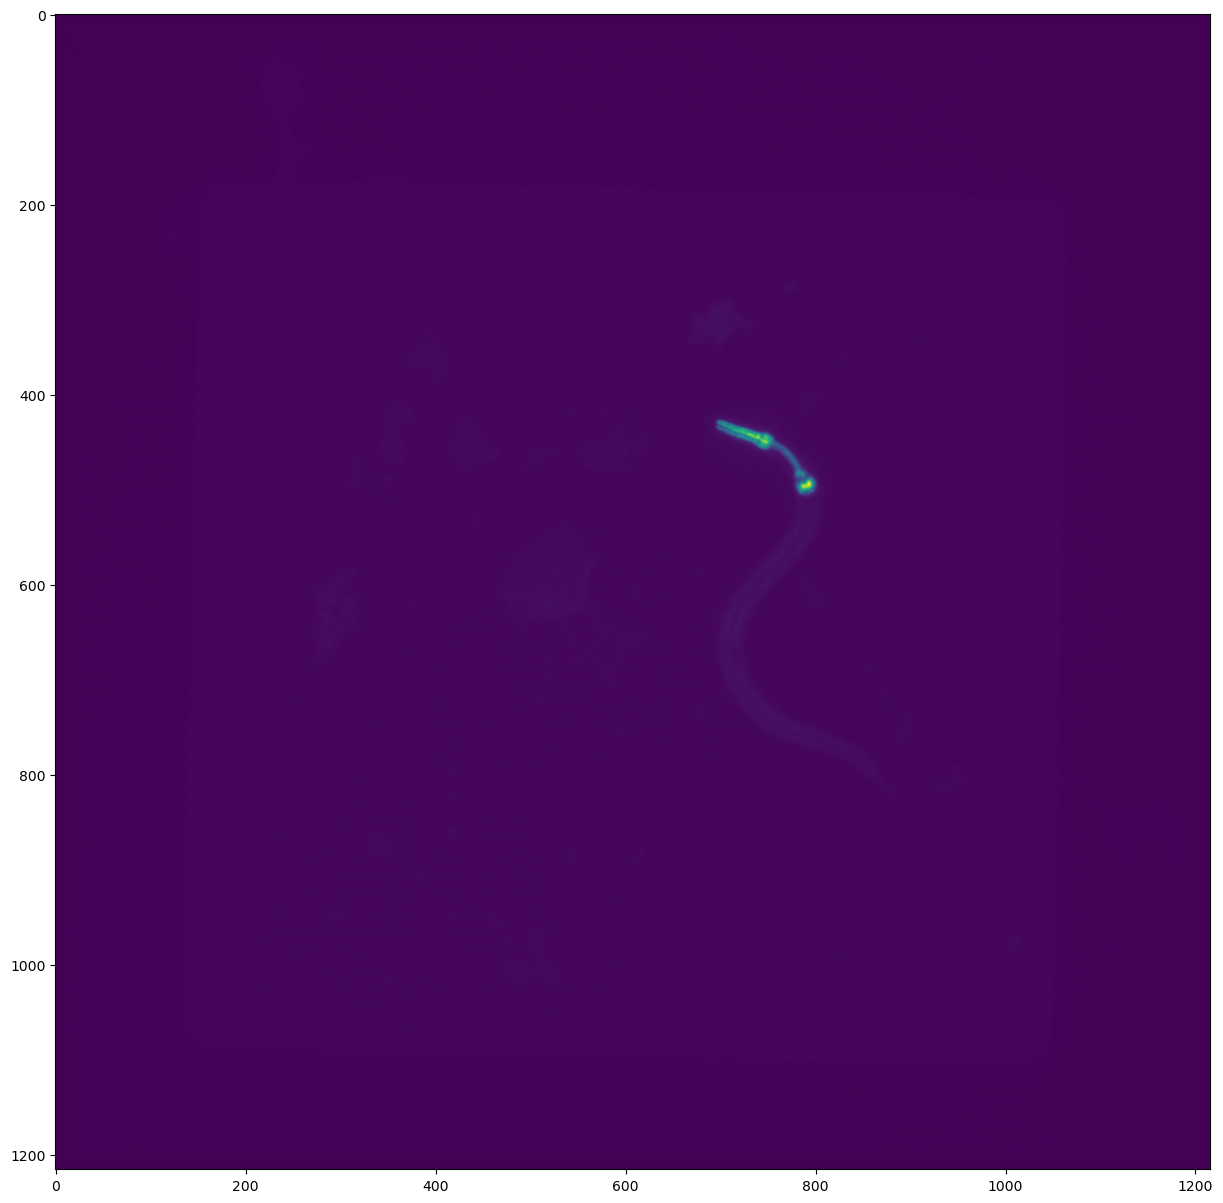

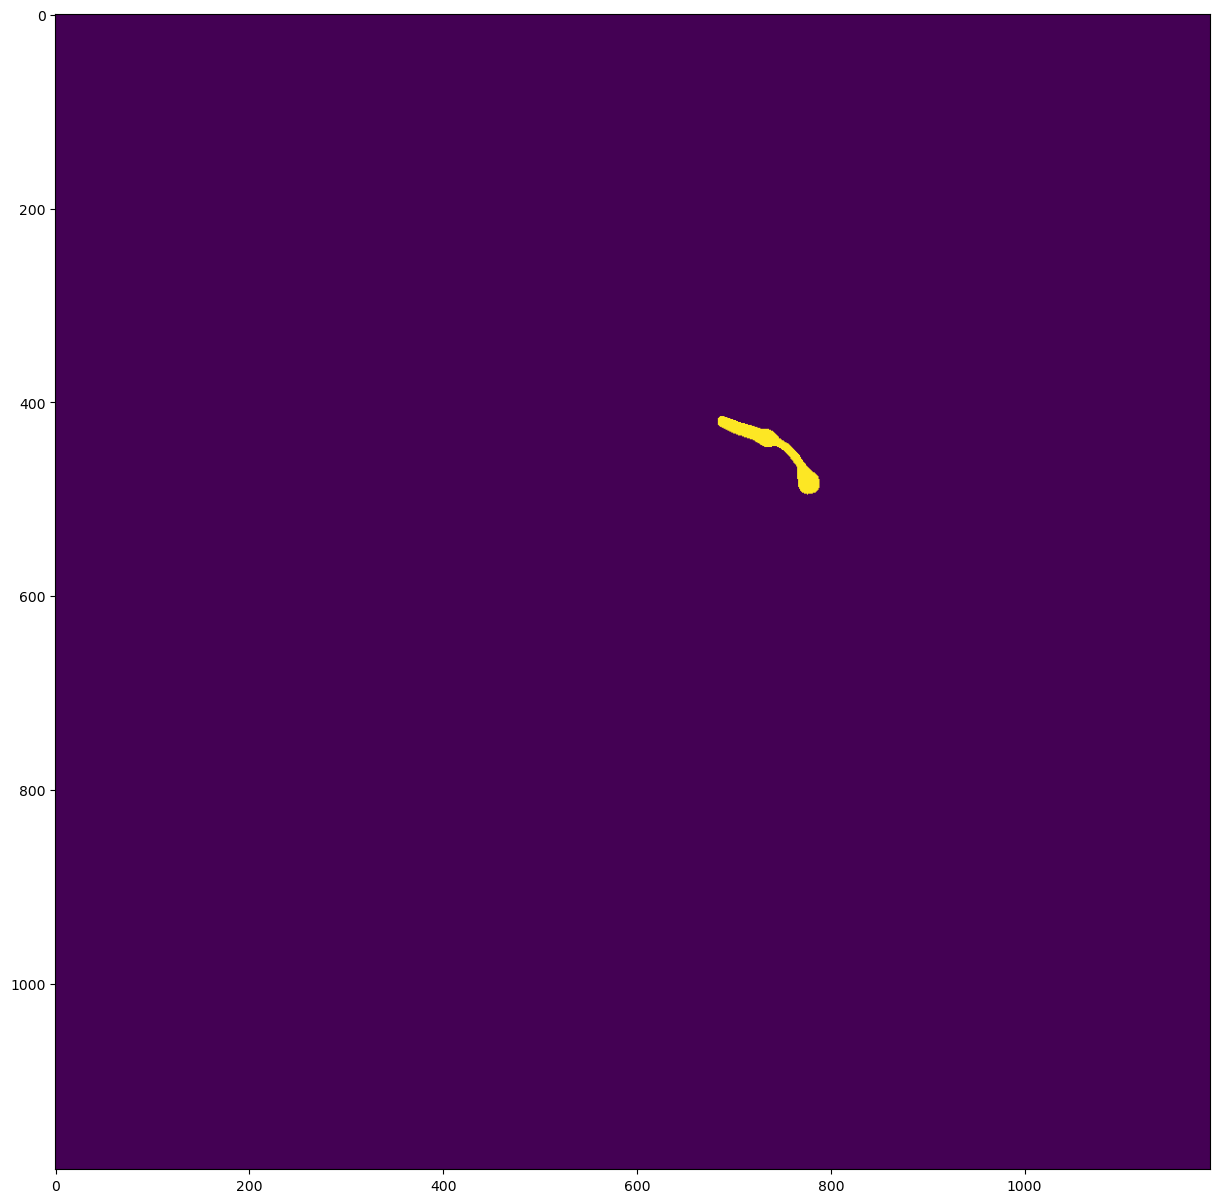

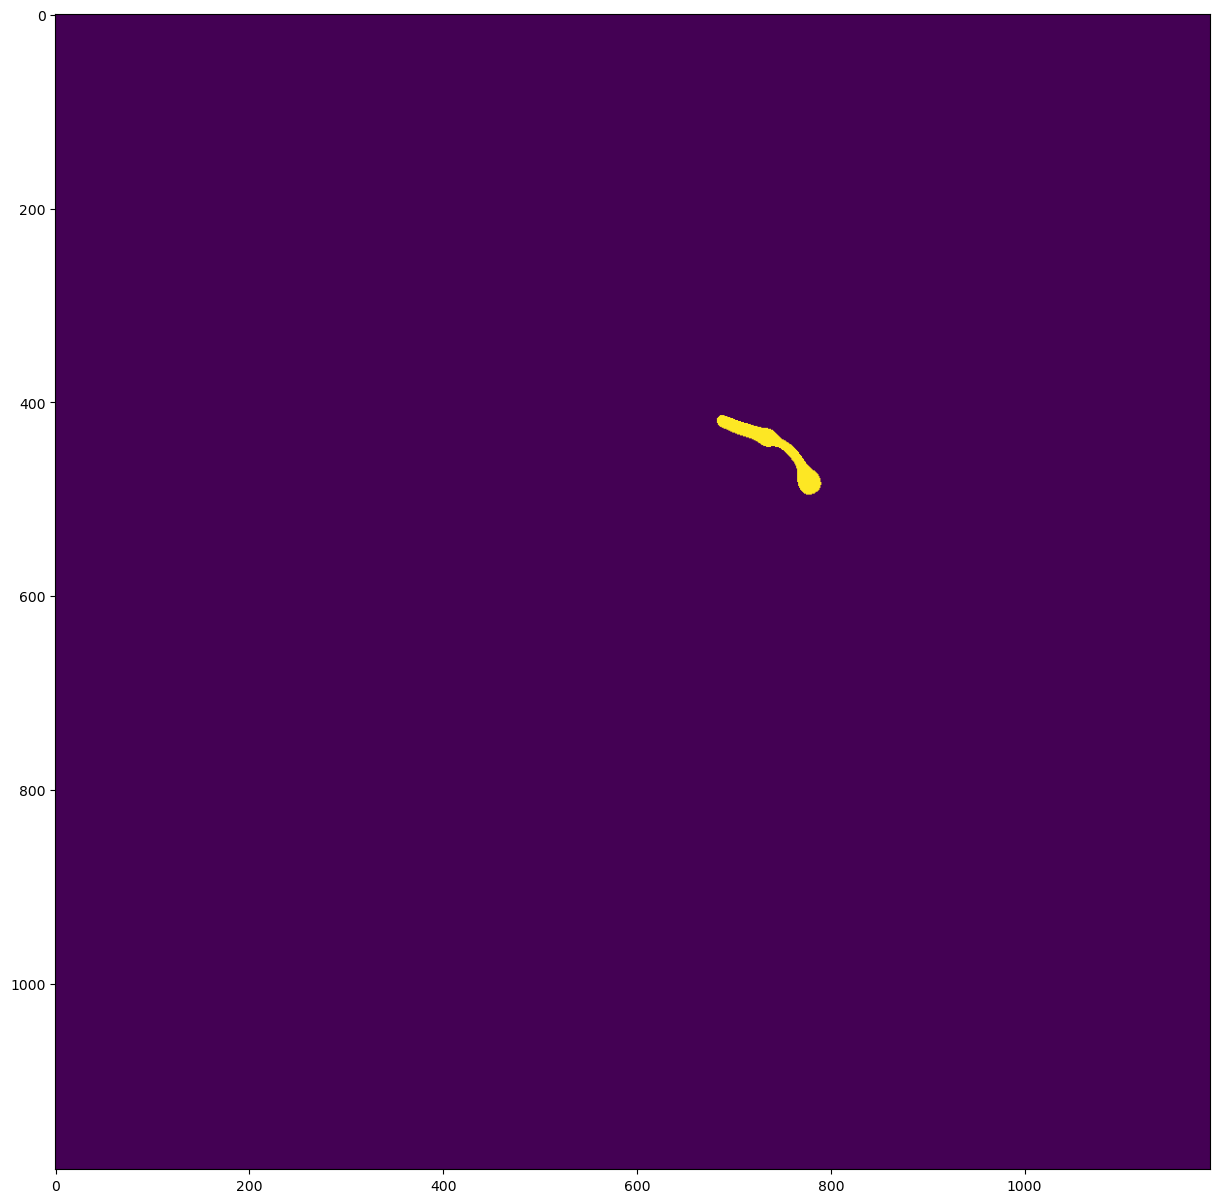

In [20]:
with torch.no_grad():
    # get the first batch
    path, img, original_shape = next(iter(dataloader))
    print(path)
    original_mask = test_dataframe.loc[test_dataframe['image'] == path[0], 'mask'].values[0]
    original_mask = image_handling.read_tiff_file(original_mask)
    original_mask = original_mask.squeeze()

    plt.figure(figsize=(15, 15))
    plt.imshow(img.squeeze())
    plt.show()
    plt.figure(figsize=(15, 15))
    plt.imshow(original_mask)
    plt.show()
    predicted_mask = model.forward(torch.tensor(img))
    predicted_mask = predicted_mask.detach().cpu().numpy()
    # predicted_mask = np.argmax(predicted_mask, axis=1)
    predicted_mask = predicted_mask[0] > 0.5


    predicted_mask = reshape_images_to_original_shape(
        predicted_mask, original_shape, padded_or_cropped="pad"
    )

    plt.figure(figsize=(15, 15))
    plt.imshow(predicted_mask[0])
    plt.show()